In [3]:
!pip install opendatasets

  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105785 sha256=e15422b7f54a39dcd7155b56f11da2c4d2e74768eb8af4464ae372aabfc96be0
  Stored in directory: /Users/sohelsiddiqui/Library/Caches/pip/wheels/46/d2/26/84d0a1acdb9c6baccf7d28cf06962ec80529fe1ad938489983
Successfully built kaggle


In [5]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Download the dataset
# od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
raw_df = pd.read_csv('weatherAUS.csv')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Impute missing numerical values
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# Scale numeric features
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Save processed data to disk
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

# Load processed data from disk
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')
train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

/var/folders/1j/99_2xjy57fs2y4v5dq3rxrg80000gn/T/ipykernel_65040/3595847691.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/var/folders/1j/99_2xjy57fs2y4v5dq3rxrg80000gn/T/ipykernel_65040/3595847691.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/var/folders/1j/99_2xjy57fs2y4v5dq3rxrg80000gn/T/ipykernel_65040/3595847691.py:42: PerformanceWarning: DataFrame is hi

Accuracy: 85.41%
Accuracy: 84.25%


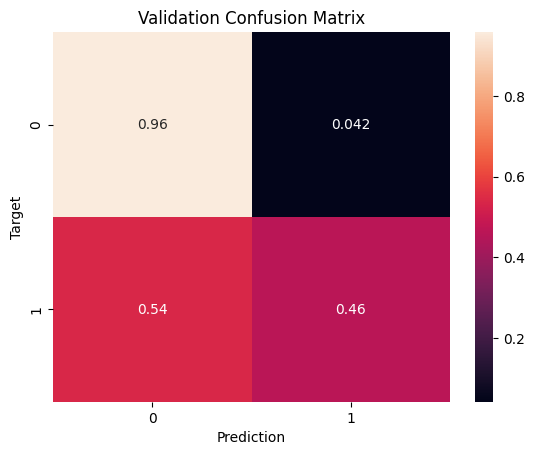

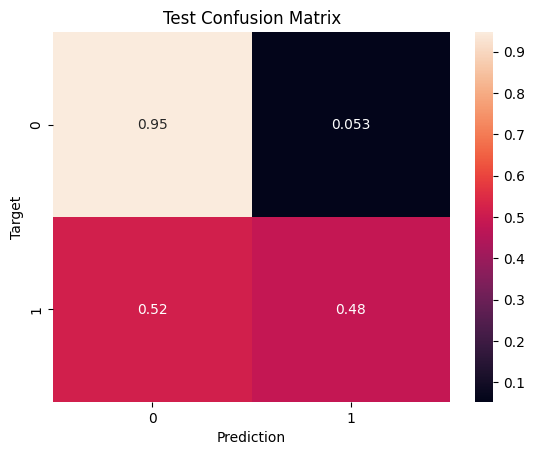

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


# Select the columns to be used for training/prediction
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Create and train the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

# Generate predictions and probabilities
train_preds = model.predict(X_train)
train_probs = model.predict_proba(X_train)
accuracy_score(train_targets, train_preds)

# Helper function to predict, compute accuracy & plot confustion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));    
    return preds

# Evaluate on validation and test set
val_preds = predict_and_plot(X_val, val_targets, 'Validation')
test_preds = predict_and_plot(X_test, test_targets, 'Test')

# Save the trained model & load it back
aussie_rain = {'model': model, 'imputer': imputer, 'scaler': scaler, 'encoder': encoder,
               'input_cols': input_cols, 'target_col': target_col, 'numeric_cols': numeric_cols,
               'categorical_cols': categorical_cols, 'encoded_cols': encoded_cols}
joblib.dump(aussie_rain, 'aussie_rain.joblib')
aussie_rain2 = joblib.load('aussie_rain.joblib')

In [10]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(new_input)

/var/folders/1j/99_2xjy57fs2y4v5dq3rxrg80000gn/T/ipykernel_65040/1630767061.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
/var/folders/1j/99_2xjy57fs2y4v5dq3rxrg80000gn/T/ipykernel_65040/1630767061.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
/var/folders/1j/99_2xjy57fs2y4v5dq3rxrg80000gn/T/ipykernel_65040/1630767061.py:5: PerformanceWarning: DataFrame is highly fragmented.  T

('Yes', np.float64(0.6316466668984417))